## Metagenome Binning
 - Recent development in high-throughput sequencing / genomic analyses of all microbes in a sample
 - Shotgun metagenomics produces a collection of reads
 - Metagenomic binning aim to reconstruct genomes from the metagenomes of microbiome samples.

## Data

In [5]:
import pandas as pd
pd.read_csv('./data/toy_example_3/count_matrix.csv', index_col=0).head()

,1775,1779,1781,1951,1773,1889,1891,1911,1913,1963,1967,345142
sample_0,27865,12446,113685,70456,28063,250,2763,123556,13804,80001,22071,0
sample_1,17560,100901,27049,70482,17419,72,22250,29471,108913,80260,20790,0
sample_2,84161,46355,42729,49924,84624,100,10347,46477,49829,56000,24874,0
sample_3,7761,76767,58623,75064,7897,140,16792,63795,82819,84978,20475,0
sample_4,22499,120087,3557,68473,22873,10,26320,3982,129474,77588,20524,0


## Existing Metagenome binning model
- Existing Metagenome binning model exhibit poor performance on shared contigs
- Do not accurately model the underlying biological process (contigs can originate from multiple genomes)
- Hierarchical Poisson Factorization (HPF)
- Flow Regularized-HPF (FR-HPF)

## Hierarchical Poisson Factorization (HPF)
- $x_{s c} \sim \operatorname{Poisson}(\theta_{s} \cdot \beta_{c})$
- $\xi{s} \sim \operatorname{Gamma}(a', a' / b')$
- $\eta_{c} \sim \operatorname{Gamma}(d', d' / e')$
- $\theta_{s k} \sim \operatorname{Gamma}(a, \xi_{s})$
- $\beta_{c k} \sim \operatorname{Gamma}(d, \eta_{c})$

## Flow Regularized - HPF
- Replace count matrix by in-out edge of assembly graph
- Added flow constraint: for each node inflow edge - outflow edge = 0
- Let $F_{ck} =  \sum_{(u, c) \in \mathcal{E}} \beta_{(u, c)}-\sum_{(c, v) \in \mathcal{E}} \beta_{(c, v)}$, then $ F_{ck} \sim \operatorname{N}(0, q)$, where parameter $q$ controls the penalty  for violating the flow constraints.

## Metagenome binning goal
- Recover $\beta$ matrix
- Identify contig to genome mapping

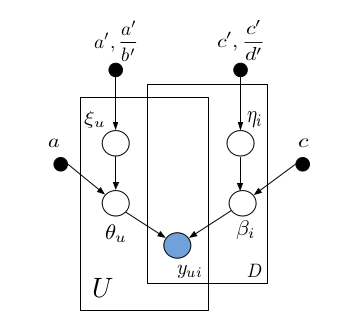

In [3]:
from IPython.display import Image
Image('./data/image/hpf.png', width=500, height=500)

## Project goal
- Analyze the performance of HPF and FR-HPF and understand why the algorithm fails
- Simulating data for FR-HPF is costly. Therefore, we want to analyze behavior of HPF for a better understanding of FR-HPF

## Prior Predictive check
- The first decision in Bayesian data analysis is specifying prior
- The goal of prior predictive check is to ensure selected priors are in a reasonable scale

## Procedure
- $\theta^{sim} \sim \operatorname{\theta}$
- $y^{sim} \sim \operatorname{P}(y|\theta^{sim})$
- Check scatter plot of $y^{sim}$, $y$ in log scale or histogram of $y^{sim}$ and $y$

In [5]:
from src.prior_predictive_check.prior_predictive import plot_prior_predictive_check

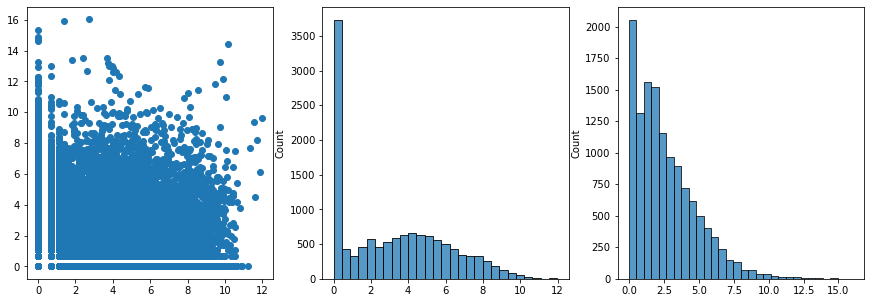

In [6]:
plot_prior_predictive_check()

## Result
- Selected hyperparameter can generate data similar scale

## HPF vs FR-HPF on Toy dataset
- K = 3, S = 10, C = 12

### Evaluation criteria
- The goal of this study was to measure how many $\beta$ vectors can be accurately recovered
- "accurately recovered": cosine similarity between $\beta_{fit}$ and $\beta_{gt}$ > 0.9
- Computed the pairwise cosine distance between each $\beta_{fit}$ and $\beta_{gt}$
- Iteratively matched $\beta_{fit}$ - $\beta_{gt}$ pair with the highest similarity
- number of $\beta$ vector recovered: the diagonal of matched similarity matrix > 0.9

In [8]:
%%time
import src.evaluator.evaluation as model_eval
from src.binning_manager.hpf import hpf
from src.binning_manager import wrapper

config = wrapper.get_hpf_config()
cm = config['stan_model_input']['count_matrix']
model_hpf = hpf.HPF(config)
model_hpf.fit(5e5, 1e5, verbose=False) # To check ELBO, set verbose=True

In [23]:
model_hpf.get_posterior()
beta_fit = model_hpf.beta_fit
cm_sample = model_hpf.cm_sample
beta_gt = wrapper.get_beta_gt('toy_example_3')
_ = model_eval.evaluate_beta_fit(beta_fit, beta_gt)

Cosine similarity:
 [[0.86324378 0.2917314  0.0414406 ]
 [0.31977096 0.75835486 0.04288318]
 [0.04164026 0.03919137 0.75401072]]
# of fitted beta vectors: 0


In [7]:
%%time
import src.evaluator.evaluation as model_eval
from src.binning_manager.frhpf import frhpf
from src.binning_manager import wrapper

config = wrapper.get_frhpf_config('toy_example_3')
model_frhpf = frhpf.FRHPF(config)
model_frhpf.fit(1e4, verbose=False) # To check ELBO, set verbose=True

In [25]:
model_frhpf.get_posterior()
beta_fit = model_frhpf.beta_fit
cm_sample = model_frhpf.cm_sample
beta_gt = wrapper.get_beta_gt('toy_example_3')
_ = model_eval.evaluate_beta_fit(beta_fit, beta_gt)

Cosine similarity:
 [[0.99889447 0.48096117 0.2184311 ]
 [0.48610416 0.99332703 0.4561543 ]
 [0.31387796 0.44582705 0.99292953]]
# of fitted beta vectors: 3


## Results
- HPF was able to approximate the general direction of $\beta$ vectors
- FR-HPF could estimate $\beta$ vectors more accurately and required fewer iterations to converge

## HPF on a more realistic dataset
- K = 5, S = 10, C = 1286

In [6]:
%%time
import src.evaluator.evaluation as model_eval
from src.binning_manager.hpf import hpf
from src.binning_manager import wrapper

config = wrapper.get_hpf_config('S10')
cm = config['stan_model_input']['count_matrix']
model = hpf.HPF(config)
model.fit(2e5, 5e4, verbose=False)

In [36]:
import numpy as np
np.set_printoptions(suppress=True)

model.get_posterior()
beta_fit = model.beta_fit
cm_sample = model.cm_sample
beta_gt = wrapper.get_beta_gt('S10')
_ = model_eval.evaluate_beta_fit(beta_fit, beta_gt)

Cosine similarity:
 [[0.41737328 0.00098754 0.00232519 0.00395968 0.00332235]
 [0.01371729 0.47418398 0.0066292  0.01115525 0.00913988]
 [0.0034647  0.00577691 0.44327464 0.01981093 0.00792288]
 [0.00093737 0.0021815  0.00234767 0.34445269 0.00571793]
 [0.00265378 0.00304718 0.00486929 0.00950326 0.40408037]]
# of fitted beta vectors: 0


## Results
- Both HPF and FR-HPF experienced a decrease in performance measure by cosine similarity to ground truth $\beta$
- FR-HPF omitted since it requires a very large dataset which is not permitted according to course policy
- The next step was to understand what cause the decrease in performance

## Posterior predictive check (PPC)
Posterior predictive check was performed to test if the model fits the data.
$$p(x|X) = \int p(x|\theta, X)p(\theta|X) ~d\theta  = \int p(x|\theta) p(\theta|X) ~d\theta$$

### Procedure:
- $\theta^{m} \sim \operatorname{\theta|y}$
- $y^{sim(m)} \sim \operatorname{P}(y|\theta^{m})$
- Compare statistics $s()$ between $y$ and $y^{sim(m)}$.
- Compute p-value = $\operatorname{min}(\operatorname{P}[s(y)<s(y^{sim})], 1-\operatorname{P}[s(y)<s(y^{sim})])$

### If the posterior samples does not agree with observation
- Model could be incorrect $p(x|\theta)$
- Posterior approximation $p(\theta|X)$ could be incorrect due to inference procedure

In [37]:
model_eval.reject_ppc_outside_ci(cm, cm_sample)

Hypothesis testing: 95% C.I. of Predictive posterior: 
% of PPC C.I. check failure: 0.011275272161741835


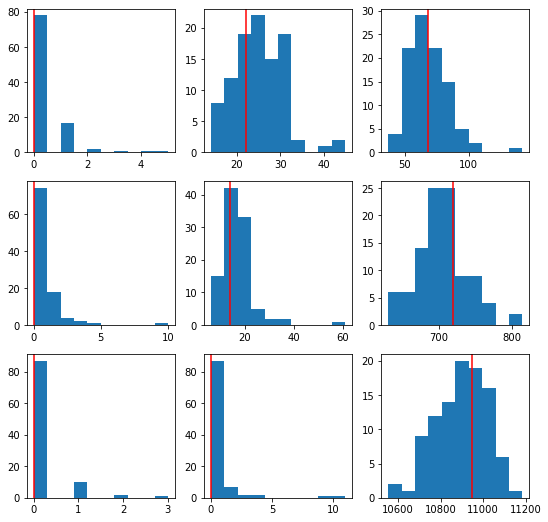

In [38]:
# PPC for count matrix[0:3, 0:3], red line indicate ground truth
model_eval.plot_ppc_simple(cm, cm_sample)

## Results
- Although fitted $\beta$ and $\theta$ did converge to ground truth, posterior predictive sample converge to count matrix
- HPF could be overfitting data / Model was too flexible to describe data


## Simulation-based calibration (SBC)
- Before check for overfitting, we want to ensure ADVI is a valid inference algorithm for HPF
- If we fix hyperparameters and generate data according to model, a valid inference algorithm should recover the generating hyperparameters
- Idea is similar to PPC:
    - PPC check for: $p(x|X)$
    - SBC check for: $p(\hat\theta|\theta)$

## Procedure:
- $\theta^{sim} \sim \operatorname{\theta}$
- $y^{sim} \sim \operatorname{P}(y|\theta^{sim})$
- $\theta^{(1)}, ..., \theta^{(S)} \sim \operatorname{P}(\theta|y^{sim})$
- Check if the rank statistic is uniformly distributed

In [4]:
%%time
from src.simulation_based_calibration.sbc import SBC

sbc = SBC(K=3, S=50, C=5)
sbc.run(40)

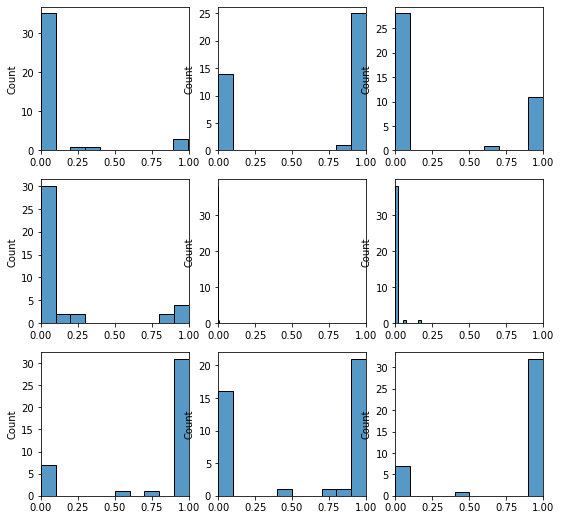

In [4]:
# SCB rank statistics for beta[0:3, 0:3]
sbc.plot_individual_SCB('beta')

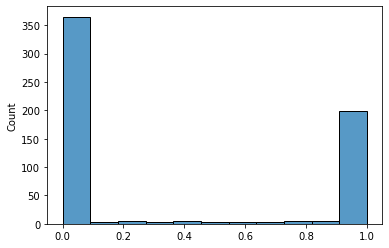

In [5]:
# SCB rank statistics for all beta
sbc.plot_aggregate_SCB('beta')

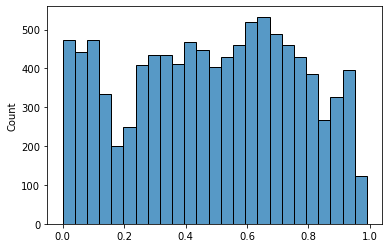

In [6]:
# SCB rank statistics for all lambda
sbc.plot_aggregate_SCB('lambda')

## Results
- SCB was inconclusive, at least ADVI cannot find accurate $\beta$ for HPF under $S/C = 10$
- The posterior sample $\beta$ did not pass rank statistic test on individual or an aggregated level
- The predictive posterior sample $x_{ij}$ only passed rank statistic test on an aggregated level
- However, failing SBC does not imply $\beta$ vectors are incorrect
- $\frac{1}{k}\theta$ and $k\beta$ should be considered a valid solution

## Model performance under limited number of samples
## Over-parametrization problem
- The model used $K(S+C)$ parameters to fit $SC$ data
- In Metagenome binning, typically only a small number of samples are available
- $C>1000$, $S~=30$ and $K~=50$
- Since $S << C$, $K(S+C) > SC$
    - $K(S+C) ~= KC = 50 \cdot (10+1e4) = 5e5$
    - $SC = 30 \cdot 1e4 = 3e5$
- We will test the model performance with different samples size


In [5]:
%%time
from src.evaluator.k_s_study import K_S_study
ksd = K_S_study()
ksd.run()

Text(0, 0.5, 'n_recovered')

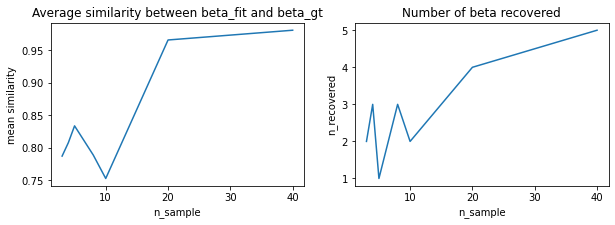

In [4]:
# Evaluating beta_fit when number of sample is increased
ksd.plot()

## Results
- A large number of samples is required for HPF to accurately fit $\beta$
- FR-HPF also showed similar behavior


## Is PPC the right metric for evaluating goodness of fit?
- We compared predictive posterior sample of HPF and FR-HPF
- We use number of rejection $x_{ij}$ on posterior predictive distribution $\{x_{sim}\}$ as measure of goodness of fit under PPC

In [26]:
# For HPF: Number of rejections based on posterior sample confidence interval

import src.evaluator.evaluation as model_eval
from src.binning_manager.hpf import hpf
from src.binning_manager import wrapper

config = wrapper.get_hpf_config()
cm = config['stan_model_input']['count_matrix']
model_hpf = hpf.HPF(config)
model_hpf.fit(5e5, 1e5, verbose=False) # To check ELBO, set verbose=True
model_hpf.get_posterior()
cm_sample = model_hpf.cm_sample

model_eval.reject_ppc_outside_ci(cm, cm_sample)

Hypothesis testing: 95% C.I. of Predictive posterior: 
% of PPC C.I. check failure: 0.0


In [32]:
# For FR-HPF: Number of rejections based on posterior sample confidence interval

import src.evaluator.evaluation as model_eval
from src.binning_manager.hpf import hpf
from src.binning_manager import wrapper

config = wrapper.get_frhpf_config('toy_example_3')
model_frhpf = frhpf.FRHPF(config)
model_frhpf.fit(1e4, verbose=False) # To check ELBO, set verbose=True
model_frhpf.get_posterior()
cm_sample = model_frhpf.cm_sample

model_eval.reject_ppc_outside_ci(cm, cm_sample)

Hypothesis testing: 95% C.I. of Predictive posterior: 
% of PPC C.I. check failure: 0.575


pp sample mean: 1554.16  | gt: 0  | ratio: 0.0
pp sample mean: 488.03  | gt: 0  | ratio: 0.0
pp sample mean: 1395.8  | gt: 0  | ratio: 0.0
pp sample mean: 717.04  | gt: 0  | ratio: 0.0
pp sample mean: 289.08  | gt: 0  | ratio: 0.0
pp sample mean: 1663.85  | gt: 0  | ratio: 0.0
pp sample mean: 1982.51  | gt: 0  | ratio: 0.0
pp sample mean: 1313.19  | gt: 0  | ratio: 0.0
pp sample mean: 683.89  | gt: 0  | ratio: 0.0


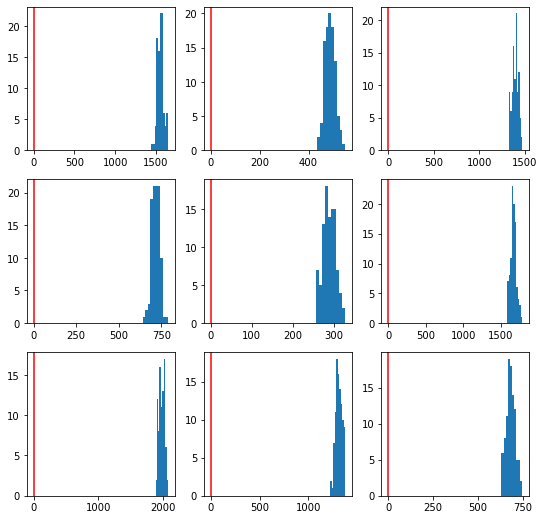

In [33]:
# PPC for FR-HPF, low values in count matrix
model_eval.plot_ppc_extreme(cm, cm_sample, 'low')

## Results
- For HPF, PPC rejection rate was 0%
- For FR-HPF, PPC rejection rate was around 60%
- For FR-HPF, PPC distribution $\{x_{sim}\}$ did not match ground truth
- However, FR-HPF fitted $\beta$ far more accurate than HPF

## Discussion
- Does this implies model of FR-HPF is incorrect?
- Does Overfitting invalidate PPC result?

## Conclusion
- HPF could not reliably fit parameters when the sample size $S$ is small relative to number of genomes $K$
- HPF is not an appropriate model for metagenome binning
- Possible improvement: injecting prior information into $\theta$ matrix
